# Long Short-Term Memory network (LSTM) Model

A powerful type of neural network specialized for handling sequence dependency is recurrent neural networks. Recurrent means the output at the current time step becomes the input to the next time step.
The **Long Short-Term Memory network** (LSTM)  due to ability to train a large architectures is used in deep learning.

This model trained using Back Propagation through time and overcomes the vanishing gradient problem. Instead of conventional neurons, LSTM networks have memory blocks that are connected through layers. It introduces many more internal parameters which must be learned (Time consuming but more flexible). The reason that makes it smarter than conventional neuron is a memory for recent sequence. 

Block contains gates to manage its state and output.
* **Forget Gate**: It decides what information should be discarded
* **Input Gate**: It decides what information should be used to update the memory
* **Output Gate**: Based on input and the memory, it decides what information should be output
The gates have weights that are learned during training process.

The same as SVM, time series data requires some preparation before being modeled LSTM. In the following, we will review the important preparation methods. Any of these methods which applies to the series requires an inverse transform to be applied on the predictions. 

## Re-structure the Dataset
Similar to the SVM modeling, we use previous observation from last times as the feature and the current time step  observation value as the target.

## Transformation
Using above transformation depends on the specifics of the data. Try with and without a given transform and compare the generated models. Many models don’t require the data to be stationary, they learn the trend/seasonality, while many methods perform better if the data is stationary.
<br/>
**Normalization**: Similar to different algorithms, LSTM is also sensitive to the range of data. This rescales the data from the original range to a new range for example between -1 and 1.
<br/>
**Differencing**: As we have discussed in ARIMA modeling section differencing can be used to remove trend or seasonal structure from the time series in order to simplify the prediction problem. The differencing can be inverted on forecasts by propagating the inversion from training data through to test data. Practically, the last real observation from training will help to invert the first forecast observation.

In the following the modeling of the data set using LSTM method will implemented.

# Hourly Energy Consumption Modeling using LSTM

In this section we will use LSTM to model our data set. First we import required libraries.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import LSTM
from math import sqrt
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

warnings.filterwarnings('ignore')

Using TensorFlow backend.


The data will be imported as follows

In [2]:
# Import data
df = pd.read_csv("Sources\EastTotalConsumption.csv", header=1, skiprows=None, parse_dates=[0], names=['datetime', 'totalconsum'])

In order to reduce the time of modeling, re-sampling (bi-weekly) is performed and plotted.

In [3]:
# Re-sampling (Daily)
df_re=df.reset_index().set_index('datetime')
df_re.index = pd.to_datetime(df_re.index)
df_re=df_re.resample('sm').mean()

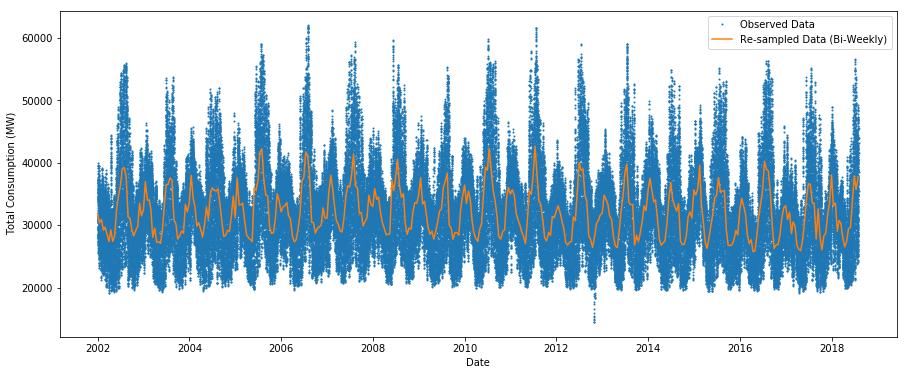

In [4]:
# Plot Original data and Re-sampled data
plt.figure(figsize=(15,6))
plt.plot(pd.to_datetime(df.datetime), df.totalconsum,'o',markersize=1)
plt.plot(df_re.index, df_re.totalconsum,'-',markersize=1, label="Train")
plt.xlabel('Date')
plt.ylabel('Total Consumption (MW)')
plt.legend(['Observed Data', "Re-sampled Data (Bi-Weekly)"])
plt.show()
df_re["datetime"]=df_re.index
df_re.drop(columns="index",inplace=True)
df_re.reset_index(drop=True, inplace=True)
df=df_re

## Train-Test Split
In order to prevent data leakage we must split data with respect to the time order in which values were observed (below figure).

Text(0.5, 0, 'Date')

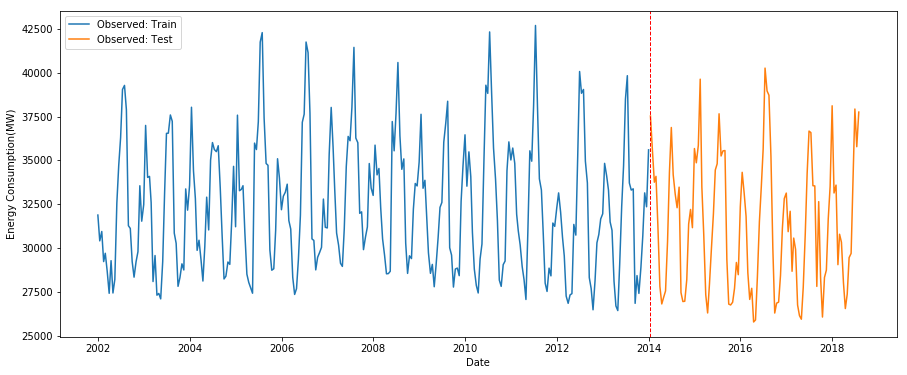

In [5]:
train_range = df[df.datetime < '2014-01-01'].index
test_range = df[df.datetime >= '2014-01-01'].index

# Plot Training and Test sets:
plt.figure(figsize=(15,6))
plt.plot(pd.to_datetime(df.datetime)[train_range], df.totalconsum[train_range],'-',markersize=1, label="Observed: Train")
plt.plot(pd.to_datetime(df.datetime)[test_range], df.totalconsum[test_range],'-',markersize=1, label="Observed: Test")
plt.axvline(pd.to_datetime(df.datetime)[test_range[0]], c='red', ls='--', lw=1)
plt.legend(loc='upper left')
plt.ylabel('Energy Consumption(MW)')
plt.xlabel('Date')

## Normalization
Due to sensitivity of LSTM to the range of data, total energy consumption values is normalized to the range -1 and 1

In [6]:
# Scale data to the range of -1 and 1:
scaler = MinMaxScaler(feature_range=(0, 1))
df["Scaled"]= scaler.fit_transform( df.totalconsum.astype(float).values.reshape(-1, 1));

# Re-structure the data set
Similar to SVM model, features generated based on the sliding window concept. It uses `Season` number of previous values as a features and current value as the target. 

In [7]:
# Defining GenerateFeatures Function using sliding window concept
def generateFeatures(value,train_range, test_range, season):
    dfg = DataFrame(value)
    columns = [dfg.shift(i) for i in range(1, season+1)]
    columns.append(dfg)
    dfg = concat(columns, axis=1)
    dfg.fillna(0, inplace=True)
    
    X_train = dfg.iloc[train_range,0:season]
    y_train = dfg.iloc[train_range, season]
    X_test = dfg.iloc[test_range, 0:season]
    y_test = dfg.iloc[test_range, season ]
    
    return X_train, y_train, X_test, y_test

# Applying the generateFeatures function to the Scaled data.
# For Biweekly data, Season is equal to 24
season = 24
X_train, y_train, X_test, y_test = generateFeatures(df["Scaled"].values.reshape(-1,1),train_range, test_range, season)

## Model Tuning 

The LSTM network works with the input data with a specific format. We need to reshape the input to 3D vector to be fed into the LSTM. The format is changed from  **[samples, features]** to **[samples, time steps, features]**.
<br />

In [8]:
# Reshape Input data and Model Parameters
X, y = X_train.values, y_train.values
X = X.reshape(X.shape[0], 1, X.shape[1])  

The shape of input data should be specified using `batch_input_shape` argument of LSTM (`See model.add(LSTM()`in the next code cell).
<br />
`Batch_size` and `nb_epoch` define how often the wights will be updated. Sensitivity analysis are performed for these two parameters to find the optimum values. 
<br />
Finally, the number of memory block (`neuron`) should be specified which is usually less than 5. 

In [9]:
batch_size=1
nb_epoch=7000
neurons=1 

Neural networks are defined in Keras as a sequence of layers. To generate the network, `Sequential` Keras API will be used  The LSTM recurrent layer comprised of memory units is called `LSTM()`.RNN can learn and remember over long sequences (`stateful=True`)
<br/>
<br/>
A fully connected layer that often follows `LSTM` layers and is used for outputting a prediction is called `Dense`.
<br/>
<br/>
`Dropout` is a a technique used to tackle Overfitting. The Dropout method takes in a float between 0 and 1, which is the fraction of the neurons to drop.
<br/>
<br/>
compilation is a pre-compute step for the network. It is always required after defining a model. the optimization algorithm (`adam`) and the objective function (`mean_squared_error`) must be selected. The default `linear` activation function will be used.


In [10]:
# Network Generation
model = Sequential()

# Properties of Single LSTM hidden layer
model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
model.add(Dense(1, name="output", activation='linear', use_bias = True, bias_initializer='ones'))
model.add(Dropout(0.01))

# Compilation process
model.compile(loss='mean_squared_error', optimizer='adam')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Once the network is compiled, it is ready to be fitted. Because the network is `stateful` we must reset the internal state using below code during fitting the training set for every epoch. Also, as we want to generate a network to learn from the sequence of energy consumption observation the `Shuffle` selection of sample should be disabled.

In [11]:
# Model fitting
for i in range(nb_epoch):
	model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
	model.reset_states() 

Instructions for updating:
Use tf.cast instead.


The result of Model fitting is shown in the following figure

Text(0.5, 0, 'Date')

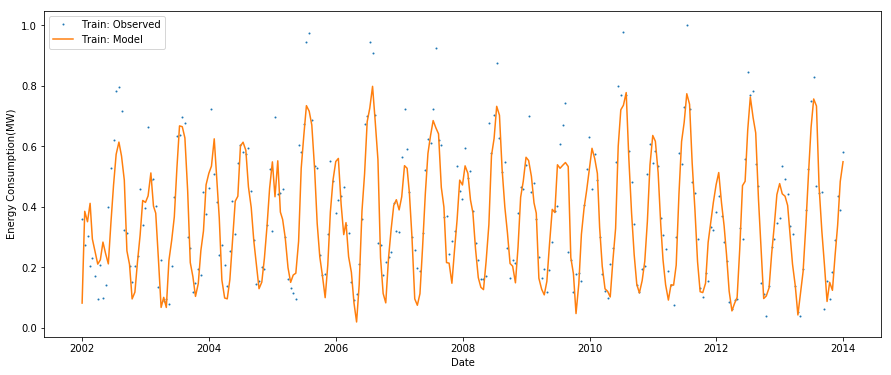

In [12]:
# Model Prediction Results 
train_reshaped = X_train.values[:, 0:season].reshape(len(X_train.values), 1, season)
model.predict(train_reshaped, batch_size=1)

# Plot predicted value for training set
plt.figure(figsize=(15,6))
plt.plot(pd.to_datetime(df.datetime)[train_range], y_train,'o',markersize=1, label="Train: Observed")
plt.plot(pd.to_datetime(df.datetime)[train_range], model.predict(train_reshaped, batch_size=1),'-',markersize=1, label="Train: Model")
plt.legend(loc='upper left')
plt.ylabel('Energy Consumption(MW)')
plt.xlabel('Date')

## Model Validation
After fitting the training set, the accuracy of model will be examine using test set. Now, we need to inverse the applied normalization.

In [13]:
# Make Prediction
predictions = list() 
yhats=list()
for i in range(len(X_test.values)):
    
	# Make one-step forecast     
	X = X_test.values[i, :]
	X = X.reshape(1, 1, len(X))
	y_test_unsc = model.predict(X, batch_size=batch_size)
	yhat=y_test_unsc[0,0] 
    
	# invert_scale    
	yhat = scaler.inverse_transform(yhat.reshape(-1,1)).flatten()
    
	predictions.append(yhat)
	yhats.append(yhat)
    

 the scores for training set is presented below

In [14]:
# Score of training set
y_train_uns=scaler.inverse_transform(model.predict(train_reshaped, batch_size=1).reshape(-1,1)).flatten()
r2_train = r2_score(df.totalconsum[train_range],y_train_uns )
print("R2  (train): {:0.3f}\n".format(r2_train))

R2  (train): 0.767



In the following we can compare the predicted values (training and test sets) with the observed data visually.

Text(0.5, 0, 'Date')

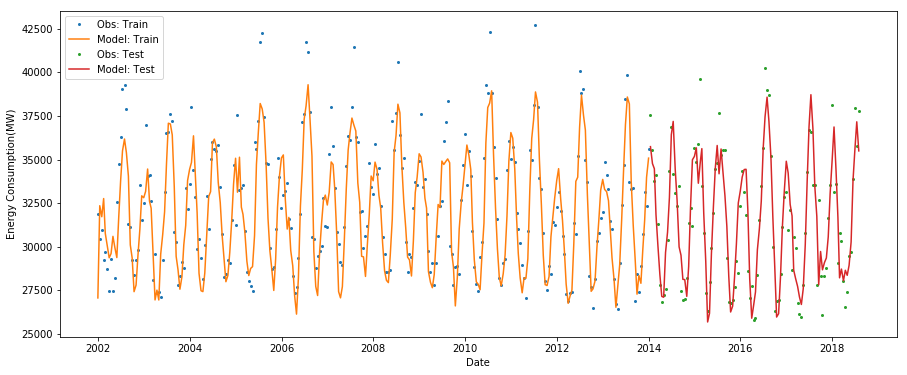

In [15]:
plt.figure(figsize=(15,6))

# Plot Observation and predicted values for training set
plt.plot(pd.to_datetime(df.datetime)[train_range], df.totalconsum[train_range],'o',markersize=2, label="Obs: Train")
plt.plot(pd.to_datetime(df.datetime)[train_range], y_train_uns,'-',markersize=1, label="Model: Train")

# # Plot Observation and predicted values for test set
plt.plot(pd.to_datetime(df.datetime)[test_range], df.totalconsum[test_range],'o',markersize=2, label="Obs: Test")
plt.plot(pd.to_datetime(df.datetime)[test_range], yhats,'-',markersize=1, label="Model: Test")

plt.legend(loc='upper left')
plt.ylabel('Energy Consumption(MW)')
plt.xlabel('Date')

The next figure shows the observed and predicted values for test set 

Text(0.5, 0, 'Date')

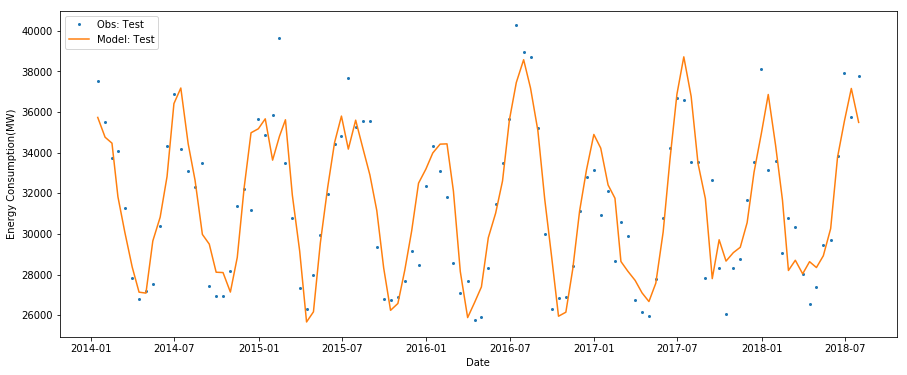

In [16]:
# Zoom: Plot Observation and predicted values for test set
plt.figure(figsize=(15,6))
plt.plot(pd.to_datetime(df.datetime)[test_range], df.totalconsum[test_range],'o',markersize=2, label="Obs: Test")
plt.plot(pd.to_datetime(df.datetime)[test_range], yhats,'-',markersize=1, label="Model: Test")
plt.legend(loc='upper left')
plt.ylabel('Energy Consumption(MW)')
plt.xlabel('Date')

Finally, the scores for test set are presented below

In [17]:
# Scores of test set
r2_test = r2_score(df.totalconsum[test_range], yhats)
mse_test = mean_squared_error(df.totalconsum[test_range], yhats)
mae_test = mean_absolute_error(df.totalconsum[test_range], yhats)

In [18]:
print("R2  (test): {:0.3f}".format(r2_test))
print("MAE (test): {:0.0f}".format(mae_test))
print("MSE (test): {:0.0f}".format(mse_test))

R2  (test): 0.761
MAE (test): 1433
MSE (test): 3355070


The Test R<sup>2</sup> using SVM method is 0.76